# Notes

In [1]:
# Promoter_Solving Modules
import numpy as np
from numpy import nan
import pandas as pd
import re

from itertools import product

from sklearn.model_selection import ParameterGrid

from sympy import *

import xgboost as xgb

from deap import algorithms, base, creator, tools

from pathlib import Path
import sys

sys.path.append('../../bitome2_workflows')
sys.path.append('../')

from promoter_solving_core import *

# Bitome Modules
%matplotlib inline
import matplotlib.pyplot as plt

from pymodulon.io import load_json_model
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
import shap
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from bitome.ml import *

sns.set_style('whitegrid')

shap.initjs()

/opt/miniconda3/envs/sym-seq-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Bitome One-Hot

## Bitome Setup

In [2]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

precise2 = load_json_model('../data/precise2.json.gz')

In [3]:
mg1655.tu_table

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,
ECK120008913,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0
ECK120008914,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0
ECK120008915,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0
ECK120008916,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0
ECK120008917,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0,4105785.0,4106379.0
...,...,...,...,...,...,...,...,...,...,...
ECK125302596,hemF,1.0,2552982.0,NaN,NaN,NaN,NaN,NaN,2552982.0,2554124.0
ECK125302597,tnaAB,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3888730.0,3891483.0
ECK125328143,aspXS,-1.0,4366951.0,NaN,NaN,NaN,NaN,NaN,4366839.0,4366951.0


In [4]:
mg1655.gene_table.loc['b1101']

left                         1157869
right                        1159302
strand                             1
pseudo                         False
name                            ptsG
cog                                G
essential                        NaN
y-ome                 well-annotated
p1k_ctrl_log_tpm            10.48346
p1k_median_log_tpm          9.618533
p1k_mad_log_tpm             1.185431
in_iM                           True
median_log_tpm              9.618533
mad_log_tpm                 0.799563
pct10_log_tpm               7.717218
pct25_log_tpm               8.596948
max_log_tpm                11.567598
min_log_tpm                 4.713658
mean_log_tpm                9.361795
skew                        -0.86243
range_log_tpm               6.853939
max_to_median               1.949065
min_to_median              -4.904874
low                            False
in_complex                      True
Name: b1101, dtype: object

In [5]:
2**10.48346*10**-6*1800/(10**-15)/(6.022*10**23)

4.279250127409589e-09

<AxesSubplot:>

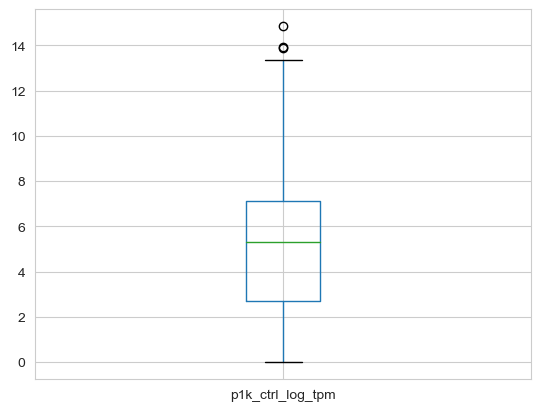

In [6]:
mg1655.gene_table.boxplot(column='p1k_ctrl_log_tpm')

### Information from the bitome

Number of TUs with $\sigma_{70}$: 1128 out of 3685 TUs
```
print(len(mg1655.tu_table))
mg1655.tu_table['sigma_factor'].value_counts(dropna=False)
```

Number of TSS with $\sigma_{70}$: 1998 out of 8799 TSS
```
print(len(mg1655.tss_table))
mg1655.tss_table['sigma_factor'].value_counts(dropna=False)
```

In [7]:
# Number of genes with only one TU
count = 0

for gene_row in mg1655.gene_table.itertuples():
    tus_for_gene = mg1655._gene_to_tus[gene_row.Index]
    if len(tus_for_gene) == 1:
        count = count+1

print(count)

"""
NOTE: 3188 genes only have one TU, could I train only on those and use to 
    predict expression of multiple TUs?
"""

3188


'\nNOTE: 3188 genes only have one TU, could I train only on those and use to \n    predict expression of multiple TUs?\n'

### Isolate Sigma 70 promoters

In [8]:
sigma_70_bool = mg1655.tu_table['sigma_factor'] == 'Sigma70'
sigma_70_bool.head()

locus_tag
ECK120008913     True
ECK120008914    False
ECK120008915    False
ECK120008916     True
ECK120008917     True
Name: sigma_factor, dtype: bool

In [9]:
sigma_70_bool.value_counts()

False    2557
True     1128
Name: sigma_factor, dtype: int64

In [10]:
conversion_dict = mg1655._gene_to_tus
gene_sigma_70_bool = pd.DataFrame(columns=['sigma_70'], index=mg1655.gene_table.index)

for gene_name in mg1655.gene_table.index:
    for locus_tag in conversion_dict[gene_name]:
        gene_sigma_70_bool.loc[gene_name] = sigma_70_bool.loc[locus_tag] # This way only the last one matters

In [11]:
gene_sigma_70_bool.value_counts()

sigma_70
False       3188
True        1152
dtype: int64

### TUs that correspond to multiple genes

### One-Hot Encoding

In [12]:
total_tpm = 0
for gene_row in mg1655.gene_table.itertuples():
    if not pd.isna(gene_row.p1k_ctrl_log_tpm):
        total_tpm = total_tpm + 2**gene_row.p1k_ctrl_log_tpm

print(total_tpm)

999005.7772312099


In [13]:
# One-Hot Encode TSS Region
one_hot_tus = mg1655.one_hot_encode_tu_promoters(n_upstream=50, n_downstream=30)
print(len(one_hot_tus)) 
one_hot_tus.head()

2270


,-50_A,-50_C,-50_G,-50_T,-49_A,-49_C,-49_G,-49_T,-48_A,-48_C,...,28_G,28_T,29_A,29_C,29_G,29_T,30_A,30_C,30_G,30_T
ECK120008913,1,0,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1
ECK120008914,0,1,0,0,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,1
ECK120008915,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
ECK120008916,0,1,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
ECK120008917,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0


In [14]:
# One-Hot Encode Local Regions
one_hot_tus_local = mg1655.one_hot_encode_tu_promoters(local_align=True, tss_radius=4, box_10_radius=10, box_35_radius=10)
print(len(one_hot_tus_local))
one_hot_tus_local.head()

# NOTE: It makes sense that there are fewer that pass this step since not all
    # reported TUs have the -10 and -35 information which local align requires

1497


,tss_-4_A,tss_-4_C,tss_-4_G,tss_-4_T,tss_-3_A,tss_-3_C,tss_-3_G,tss_-3_T,tss_-2_A,tss_-2_C,...,-35_8_G,-35_8_T,-35_9_A,-35_9_C,-35_9_G,-35_9_T,-35_10_A,-35_10_C,-35_10_G,-35_10_T
ECK120008913,1,0,0,0,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,0
ECK120008914,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
ECK120008915,0,1,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
ECK120008916,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
ECK120008917,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


### -10 Binding Strength vs k_d_RNAP

In [15]:
box10_raw = pd.read_csv('/Users/gchhughes/Github/Strainware-s/workflows_CAD/data/bitome2/mg1655/box10_raw.csv')
box10_avg = pd.read_csv('/Users/gchhughes/Github/Strainware-s/workflows_CAD/data/bitome2/mg1655/box10_average.csv')

In [16]:
box10_raw = box10_raw.sort_values('ID')
box10_raw = box10_raw.set_index('ID')
box10_raw = box10_raw.drop(columns='Unnamed: 0')
box10_raw

,TU,tss,best score,name,Sigma70_Prib_score,Sigma54_Prib_score,Sigma32_Prib_score,Sigma24_Prib_score,Sigma38_Prib_score,Sigma28_Prib_score
ID,,,,,,,,,,
b0008,ECK120015352,8191,NaN,talB,-4.060455,-8.198982,-7.955531,-10.651741,-9.928691,-10.367675
b0014,ECK120009450,12048,NaN,dnaK,-8.656225,-7.998311,-2.406977,-13.539338,-12.002935,-11.339085
b0014,ECK120009602,12123,NaN,dnaK,-6.814542,-7.868740,-4.664100,-6.892363,-6.891801,-9.718597
b0014,ECK120009603,12144,NaN,dnaK,-6.423808,-6.853179,-4.053554,-7.573814,-8.975101,-7.717936
b0015,ECK120009450,12048,NaN,dnaJ,-8.656225,-7.998311,-2.406977,-13.539338,-12.002935,-11.339085
...,...,...,...,...,...,...,...,...,...,...
b4704,ECK125135010,3658054,NaN,arrS,-2.906711,-7.182434,-11.613245,-10.290450,-5.807788,-11.632860
b4705,ECK125140764,853064,NaN,mntS,-2.491405,-6.429695,-6.018359,-10.880716,-6.030012,-12.554861
b4707,ECK125145760,4019978,NaN,esrE,-8.105672,-5.722159,-9.134038,-5.734910,-10.820441,-10.182100


In [17]:
box10_avg = box10_avg.sort_values('ID')
box10_avg = box10_avg.set_index('ID')
box10_avg = box10_avg.drop(columns='Unnamed: 0')
box10_avg

,best score,name,Sigma70_Prib_score,Sigma54_Prib_score,Sigma32_Prib_score,Sigma24_Prib_score,Sigma38_Prib_score,Sigma28_Prib_score
ID,,,,,,,,
b0008,-4.060455,talB,-4.060455,-8.198982,-7.955531,-10.651741,-9.928691,-10.367675
b0014,-3.708210,NaN,-7.298192,-7.573410,-3.708210,-9.335171,-9.289946,-9.591873
b0015,-3.708210,NaN,-7.298192,-7.573410,-3.708210,-9.335171,-9.289946,-9.591873
b0019,-3.378301,NaN,-3.378301,-6.026667,-9.882200,-10.388437,-6.601391,-9.528320
b0020,-3.378301,NaN,-3.378301,-6.026667,-9.882200,-10.388437,-6.601391,-9.528320
...,...,...,...,...,...,...,...,...
b4704,-2.906711,arrS,-2.906711,-7.182434,-11.613245,-10.290450,-5.807788,-11.632860
b4705,-2.491405,mntS,-2.491405,-6.429695,-6.018359,-10.880716,-6.030012,-12.554861
b4707,-5.722159,esrE,-8.105672,-5.722159,-9.134038,-5.734910,-10.820441,-10.182100


In [18]:
mg1655.tu_table.loc[mg1655._gene_to_tus['b0019']]

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,
ECK120009006,nhaAR,1.0,17317.0,Sigma38,17303.0,17313.0,17286.0,17291.0,17317.0,19620.0
ECK120009391,nhaAR,1.0,17458.0,Sigma70,17445.0,17450.0,17424.0,17429.0,17458.0,19620.0


### Average One-Hot

In [94]:
"""
General workflow of this code block:
1. Iterate over all genes in the mg1655 gene table
2. For each gene, create a list of all TUs for that gene (tus_for_gene)
3. Iterate over tus_for_gene and return the subset of that list that have known 
    one-hots (from one_hot_tus above)
4. Check that the current gene has expression data
5. Average the one-hot encoded TUs and append it to the list

2488 genes pass this process when one-hot is based on TSS
1850 genes pass when one-hot is based on local regions

NOTE: Workflow is the same for the local aligned one-hots, but I'm not sure why
    the local encoding results in fewer TUs
"""
# Prepare Feature Matrices
Xy_to_try = {}

gene_names_avg = []
gene_exps_avg = []
gene_oh_rows_avg = []

gene_names_local_avg = []
gene_exps_local_avg = []
gene_oh_rows_local_avg = []

gene_names_70_local_avg = []
gene_exps_70_local_avg = []
gene_oh_rows_70_local_avg = []

for gene_row in mg1655.gene_table.itertuples():
    
    # handle the normal 1-hot
    tus_for_gene = mg1655._gene_to_tus[gene_row.Index]
    tus_in_onehot = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus.index)]
    gene_tpm = gene_row.p1k_ctrl_log_tpm # Make sure to update
    if tus_in_onehot and not pd.isna(gene_tpm):
        tu_one_hots = one_hot_tus.loc[tus_in_onehot, :]
        tu_one_hot_avg = tu_one_hots.mean(axis=0)
        gene_names_avg.append(gene_row.Index)
        gene_exps_avg.append(2**gene_tpm) # Change depending on which gene table is used
        gene_oh_rows_avg.append(tu_one_hot_avg)

    # handle the local-aligned 1-hot
    tus_in_oh_loc = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus_local.index)]
    if tus_in_oh_loc and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots_loc = one_hot_tus_local.loc[tus_in_oh_loc, :]
        tu_one_hot_avg_loc = tu_one_hots_loc.mean(axis=0)
        gene_names_local_avg.append(gene_row.Index)
        gene_oh_rows_local_avg.append(tu_one_hot_avg_loc)
        gene_exps_local_avg.append(2**gene_tpm) # Change depending on which gene table is used

In [95]:
for gene_row in mg1655.gene_table.itertuples():
    
    # handle the normal 1-hot
    print(mg1655._gene_to_tus[gene_row.Index])

['ECK120009369', 'ECK125145761']
['ECK120009369']
['ECK120009369']
['ECK120009369']
['ECK120026504']
['ECK120026505']
['ECK120026506']
['ECK120015352']
['ECK120026507']
['ECK120026508']
['ECK120026509']
['ECK120020482']
['ECK120009450', 'ECK120009602', 'ECK120009603']
['ECK120009450', 'ECK120009602', 'ECK120009603']
['ECK120026510']
['ECK120026511']
['ECK120026511']
['ECK120026512']
['ECK120009006', 'ECK120009391']
['ECK120009006', 'ECK120009391', 'ECK120030129']
['ECK120026513']
['ECK120026513']
['ECK120015339', 'ECK120015340']
[]
['ECK120009479']
['ECK120009479', 'ECK120030634', 'ECK120030635', 'ECK120033554']
['ECK120009479', 'ECK120029296', 'ECK120030634', 'ECK120030635', 'ECK120033554']
['ECK120009479', 'ECK120029296', 'ECK120030634', 'ECK120030635', 'ECK120033554']
['ECK120009479', 'ECK120029296', 'ECK120030634', 'ECK120030635', 'ECK120033554']
['ECK120026514']
['ECK120011048', 'ECK120030636']
['ECK120009301', 'ECK120009302']
['ECK120009301', 'ECK120009302', 'ECK120011049']
['ECK

In [96]:
# sigma70 local-aligned 1-hot
gene_names_local_avg_70 = [i for (i,v) in zip(gene_names_local_avg, gene_sigma_70_bool.values) if v]
gene_exps_local_avg_70 = [i for (i,v) in zip(gene_exps_local_avg, gene_sigma_70_bool.values) if v]
gene_oh_rows_local_avg_70 = [i for (i,v) in zip(gene_oh_rows_local_avg, gene_sigma_70_bool.values) if v]

## Setup Parameter Grid DataFrame

In [97]:
# Sequence Specific
log_default = {
    'k_d_RNAP': [-7,-5],
    #'k_eq_opening': [-1,1],
    'k_escape': [-3,1], # Consider changing to [-2,1]
    #'k_d_TF': [-1,1],
}

log_test = {
    'k_d_RNAP': [-7,-5],
    'TFI': [0,0],
    'k_escape': [-3,1],
}

# Generic
kinetic_default = [
    10**-6, # RNAP
    0, # TF
    1/3600, # u, growth rate
    300, # t_half_life_deg
    10**-9, # promoter_conc
    0, # Placeholder for k_deg
]

kinetic_default[5] = np.log(2)/kinetic_default[3]

# mRNA Data
mRNA_default = [
    1800, # mRNA_total: Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    10**-15, # v_cell: L from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    0, # Placeholder for gene_TPM: # mRNA/million mRNA
]

# NOTE: We are predicting mRNA_target, measured as Mol mRNA/cell, not mRNA expression directly

### Distribution of calculated mRNA_target data

In [22]:
test_df = pd.DataFrame(columns=['mRNA_target'], index=gene_names_local_avg)
for i, expression in enumerate(gene_exps_local_avg):
    mRNA_default[2] = expression
    test_df.iloc[i,0] = (calculate_mRNA_target(mRNA_default))

mRNA_default[2] = 0
test_df['mRNA_target'] = test_df['mRNA_target'].astype(float)

print(test_df.max())

mRNA_target    4.615132e-08
dtype: float64


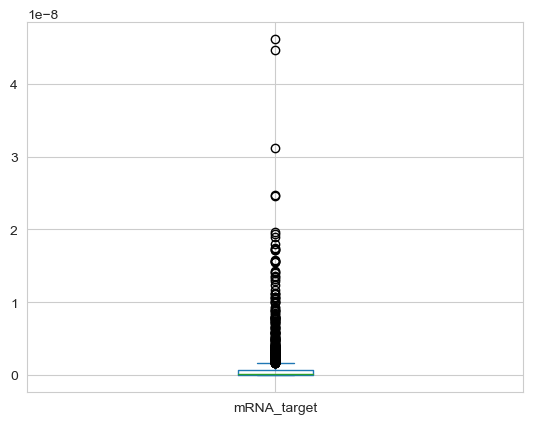

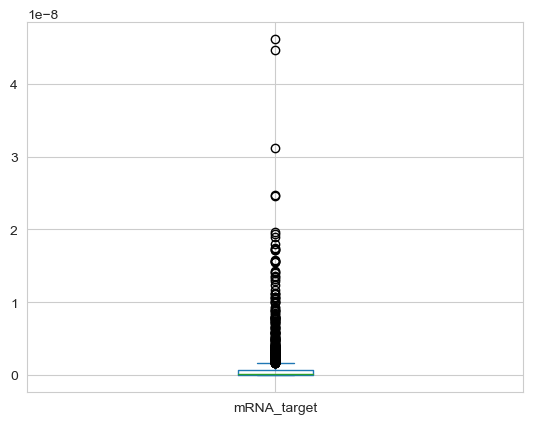

In [23]:
ax = test_df.plot.box()
ax.figure

### Create k_grid

In [38]:
k_df = k_grid(gene_exp = gene_exps_avg, # Need to change
              gene_name = gene_names_avg, # Need to change
              kinetic_data = kinetic_default,
              mRNA_data = mRNA_default,
              num_steps=3,
              **log_default)
k_df.head()

,log10_mRNA_target,parameter_grid
gene_name,,
b0001,-8.401934,"[(-7.0, -0.5944885496181157, -1.33516843832365..."
b0002,-8.419476,"[(-7.0, -0.5944885496181157, -1.35343147531402..."
b0003,-8.519511,"[(-7.0, -0.5944885496181157, -1.45705217586046..."
b0004,-8.522096,"[(-7.0, -0.5944885496181157, -1.45971811654274..."
b0008,-8.30838,"[(-7.0, -0.5944885496181157, -1.23720503367696..."


In [40]:
k_df.loc['b1101']

log10_mRNA_target                                            -8.368632
parameter_grid       [(-7.0, -0.5944885496181157, -1.30040956358113...
Name: b1101, dtype: object

## Profile Models

### Understanding why basic elastic net fails

In [ ]:
regrCV = ElasticNetCV(cv=5, random_state=0,l1_ratio=0.001)
regrCV.fit(Xy_train['k_d_RNAP_med'][0],Xy_train['k_d_RNAP_med'][1])
regrCV_params = regrCV.get_params()

print(regrCV.score(Xy_train['k_d_RNAP_med'][0],Xy_train['k_d_RNAP_med'][1]))
print(regrCV.score(Xy_lockbox['k_d_RNAP_med'][0],Xy_lockbox['k_d_RNAP_med'][1]))

# [alphas, coefs, dual_gaps, n_iters] = regrCV.path

In [ ]:
print(regrCV.score(Xy_train['k_d_RNAP_med'][0],Xy_train['k_d_RNAP_med'][1]))
print(regrCV.score(Xy_lockbox['k_d_RNAP_med'][0],Xy_lockbox['k_d_RNAP_med'][1]))

In [ ]:
regr = ElasticNet(random_state=0,l1_ratio=0.001,alpha=regrCV.alpha_)
regr.fit(Xy_train['k_d_RNAP_med'][0],Xy_train['k_d_RNAP_med'][1])
regr_params = regr.get_params()

print(regr.score(Xy_train['k_d_RNAP_med'][0],Xy_train['k_d_RNAP_med'][1])-regrCV.score(Xy_train['k_d_RNAP_med'][0],Xy_train['k_d_RNAP_med'][1]))
print(regr.score(Xy_lockbox['k_d_RNAP_med'][0],Xy_lockbox['k_d_RNAP_med'][1])-regrCV.score(Xy_lockbox['k_d_RNAP_med'][0],Xy_lockbox['k_d_RNAP_med'][1]))

In [ ]:
regr_params


In [ ]:
regrCV_params

### Profile Models using Cam's Workflow

In [ ]:
models_to_try = {
    #'ElasticNet': ElasticNet(),
    'ElasticNetCV': ElasticNetCV(),
    #'SVR': SVR(),
    #'RF': RandomForestRegressor(n_jobs=4),
    #'NN': MLPRegressor(),
    #'XGB': xgb.XGBRegressor(),

}

In [ ]:
model_profile_df, ax_train, ax_val = profile_xy_and_models(Xy_train, models_to_try, scoring='r2', n_cv=5,
                                                           x_preprocessing=['standard'],y_preprocessing=['log10'],
                                                           verbose=True)

# GA Testing

### Sequence DataFrame

In [37]:
sequence_df = pd.DataFrame(gene_oh_rows_avg,index=gene_names_avg) # Need to change
print(len(sequence_df))
sequence_df

2488


,-50_A,-50_C,-50_G,-50_T,-49_A,-49_C,-49_G,-49_T,-48_A,-48_C,...,28_G,28_T,29_A,29_C,29_G,29_T,30_A,30_C,30_G,30_T
b0001,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
b0002,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
b0003,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
b0004,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
b0008,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4397,0.500000,0.000000,0.000000,0.500000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.500000,0.500000,0.5,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000
b4398,0.500000,0.000000,0.000000,0.500000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.500000,0.500000,0.5,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000
b4399,0.500000,0.000000,0.000000,0.500000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.500000,0.500000,0.5,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000
b4400,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.500000,0.5,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000


### Train/Test Splits

In [50]:
seed = 42
test_size = 0.1

# Divide data into GA and test sets for predicting mRNA expression
GA_x_train, test_x_lockbox, GA_y_train, test_y_lockbox = train_test_split(sequence_df,k_df,test_size=test_size,random_state=seed)

# Divide GA data into train and test sets for predicting parameters
x_train, x_lockbox, y_train, y_lockbox = train_test_split(GA_x_train,GA_y_train,test_size=test_size,random_state=seed)

In [51]:
x_train.head()

,-50_A,-50_C,-50_G,-50_T,-49_A,-49_C,-49_G,-49_T,-48_A,-48_C,...,28_G,28_T,29_A,29_C,29_G,29_T,30_A,30_C,30_G,30_T
b0319,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
b2490,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
b2820,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
b0386,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
b3521,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [52]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2015 entries, b0319 to b1042
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   log10_mRNA_target  2015 non-null   object
 1   parameter_grid     2015 non-null   object
dtypes: object(2)
memory usage: 47.2+ KB


In [53]:
creator.create(name = 'FitnessMin',
               base = base.Fitness,
               weights = (-1.0,))

creator.create(name = 'individual',
               base = np.ndarray,
               fitness = creator.FitnessMin)

A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
A class named 'individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.


In [54]:
toolbox = base.Toolbox()

# Function to pick initial parameters
import random
seed = 42
random.seed(seed)

def generate_individual(individual_class: type,
                        train_df: pd.DataFrame):
    """
    Create a np.ndarray for each individual where the rows correspond to the 
        genes and the columns the parameters
    :param individual_class: Class which the individual will inherit
    :param pd.DataFrame train_df: df containing gene names, mRNA expression, and
        the parameter grid
    """

    individual = individual_class(random.sample(grid,1)[0] 
                                  for grid in train_df['parameter_grid'])
    
    return individual

In [55]:
toolbox.register(alias = 'individual', 
                 function = generate_individual, 
                 individual_class = creator.individual,
                 train_df = y_train)

toolbox.register('population', 
                 tools.initRepeat,
                 list,
                 toolbox.individual)

In [56]:
# Define individual and population using generate_individual
parameter_list = ['k_d_RNAP','k_escape','k_eq_opening']

test_population = toolbox.population(n=3)

#### Histograms for Variance

In [57]:
variance_population = toolbox.population(n=1000)

In [58]:
# Focus on highest expression in y_train
max_index = np.argmax(y_train['log10_mRNA_target'])
min_index = np.argmin(y_train['log10_mRNA_target'])
max_name = y_train.index[max_index]
min_name = y_train.index[min_index]

med_name = y_train[y_train['log10_mRNA_target']==y_train['log10_mRNA_target'].quantile(interpolation='lower')].index[0]
med_index = y_train.index.get_loc(med_name)

max_k_d = list()
max_k_esc = list()
max_k_eq = list()
med_k_d = list()
med_k_esc = list()
med_k_eq = list()
min_k_d = list()
min_k_esc = list()
min_k_eq = list()

for i, prediction_df in enumerate(variance_population):
    max_k_d.append(variance_population[i][max_index][0])
    max_k_esc.append(variance_population[i][max_index][1])
    max_k_eq.append(variance_population[i][max_index][2])

    med_k_d.append(variance_population[i][med_index][0])
    med_k_esc.append(variance_population[i][med_index][1])
    med_k_eq.append(variance_population[i][med_index][2])

    min_k_d.append(variance_population[i][min_index][0])
    min_k_esc.append(variance_population[i][min_index][1])
    min_k_eq.append(variance_population[i][min_index][2])


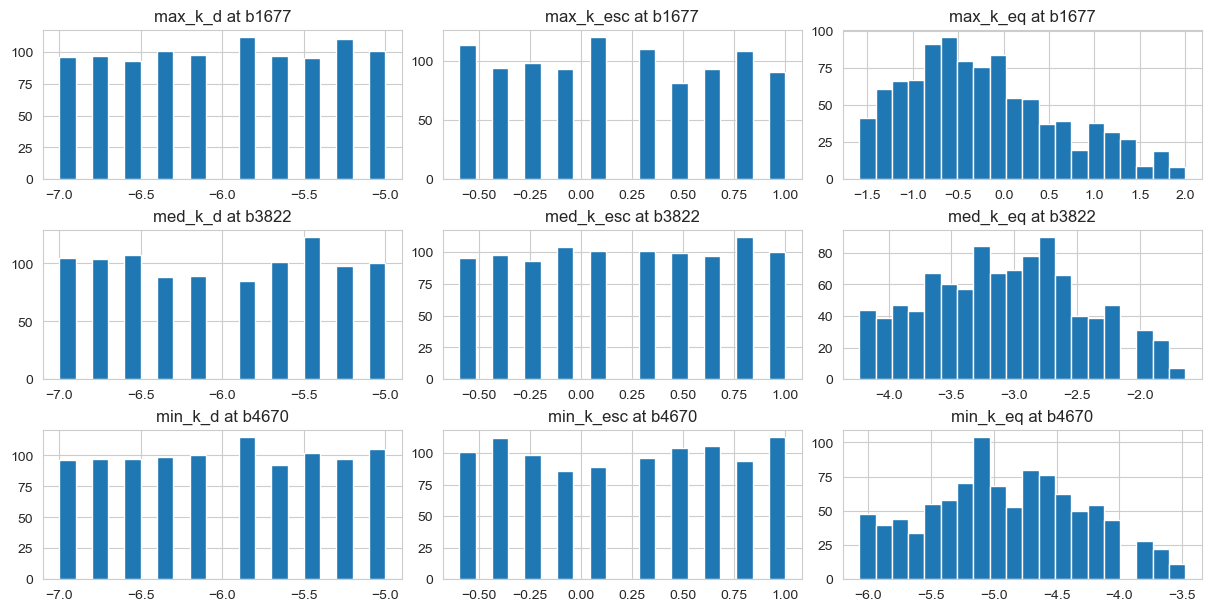

In [59]:
# Plot histograms
prefixes = ['max_', 'med_', 'min_']
suffixes = ['k_d', 'k_esc', 'k_eq']
gene_names = [max_name, med_name, min_name]

fig, axs = plt.subplots(3,3, figsize=(12,6), layout='constrained')
bins = 20

for i, prefix in enumerate(prefixes):
    for ii, suffix in enumerate(suffixes):
        string = prefix+suffix
        axs[i, ii].hist(x=locals()[string], bins=bins)
        axs[i, ii].set_title(f'{string} at {gene_names[i]}')

plt.show()

### Fitness
Wrap objective_function in DEAP framework

In [60]:
# Define fitness functions for an individual
def objective_function(individual: object, 
                        parameter_list: list,
                        kinetic_data: list,
                        model,
                        x_train_df: pd.DataFrame, 
                        x_test_df: pd.DataFrame, 
                        y_test_df: pd.DataFrame,):
    """
    Train a model to predict parameter values based on the promoter sequence.
    
    :param object individual: DEAP individual object
    :param list parameter_list: List containing names of each parameter
    :param list kinetic_data: List of generic values for promoter_equation
    :param model: Sklearn wrapped model
    :param pd.DataFrame train_df: One-hot encoding of train genes
    :param pd.DataFrame test_df: One-hot encoding of lockbox genes
    :param pd.DataFrame y_test_df: df containing mRNA expression values

    TODO: Hyperparameter optimization for ElasticNetCV
    TODO: Save parameters for each model so that we can look at them
        - May require custom algorithm
    """
    
    # Create a prediction pd.DataFrame
    prediction_df = pd.DataFrame(columns = parameter_list + ['mRNA_prediction'], 
                                index = x_test_df.index)

    # Create models for each parameter
    for i in range(len(parameter_list)):
        fit_model = model.fit(x_train_df, individual[:,i])
        prediction_df.iloc[:,i] = fit_model.predict(x_test_df)

    # Predict mRNA and calculate the RMSE
    for i in range(prediction_df.shape[0]):
        parameter_tuple = tuple(prediction_df.iloc[i])
        prediction_df.iloc[i,-1] = promoter_equation(kinetic_data, 0, 'mRNA', 
                                                    parameter_tuple)
    
    pred_ob = prediction_df.iloc[:,-1]-y_test_df.iloc[:,0] # Difference between predicted and observed values
    ob_med = y_test_df.iloc[:,0].median()
    rmse = ((pred_ob)**2).mean()**0.5
    norm_rmse = abs(rmse/ob_med)

    return norm_rmse,

In [31]:
parameter_list = ['k_d_RNAP','k_escape','k_eq_opening']

#model = ElasticNetCV(cv=5, random_state=42,l1_ratio=0.001)
model = xgb.XGBRegressor()

toolbox.register(alias = 'evaluate',
                 function = objective_function, 
                 parameter_list = parameter_list, 
                 kinetic_data = kinetic_default,
                 model = model, 
                 x_train_df = x_train, 
                 x_test_df = x_lockbox, 
                 y_test_df = y_lockbox,)

NameError: name 'toolbox' is not defined

In [32]:
norm_rmse = toolbox.evaluate(test_population[1])
print(norm_rmse)

NameError: name 'toolbox' is not defined

### Selection

In [41]:
# NOTE: Not sure what appropriate tournament size should be
toolbox.register("select", tools.selTournament, tournsize=5)

# NOTE: Using np.ndarray individuals requires a different method to compare individuals
hof = tools.HallOfFame(3, similar=np.array_equal)

### Mutation

In [42]:
import random
seed = 42
random.seed(seed)

def mutate(individual: object, 
           genepb: float, 
           train_df: pd.DataFrame):
    """
    Assign a new set of random parameters to a gene

    :param object individual: Individual object
    :param float genepb: Independent pobability a gene will be mutated [0,1]
    :param pd.DataFrame train_df: df containing gene names, mRNA expression, and
        the parameter grid

    NOTE: Do I need to set the random seed within the function?
    """

    for i, gene in enumerate(individual):
        if random.random() < genepb:
            individual[i] = random.sample(train_df.iloc[i,1],1)[0]

    return individual,

In [43]:
genepb_mt = 0.1 # Probability gene will be mutated

toolbox.register(alias = "mutate",
                 function = mutate,
                 genepb = genepb_mt,
                 train_df = y_train,)

In [44]:
print(test_population[0])
test_evaluation = toolbox.evaluate(test_population[0])
print(test_evaluation)
test_mutate, = toolbox.mutate(test_population[0])
print(test_mutate)
print(toolbox.evaluate(test_mutate))

[[-5.22222222 -0.66887426 -2.78854455]
 [-6.77777778 -0.28087304 -4.04121279]
 [-7.         -0.36550834 -1.83966044]
 ...
 [-6.11111111  0.34586621 -2.41832664]
 [-5.22222222  0.37417215 -3.39119915]
 [-5.          0.16556287 -1.28252457]]


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


(0.06568734197796194,)
[[-5.22222222 -0.66887426 -2.78854455]
 [-6.33333333 -0.02469843 -4.19881444]
 [-7.         -0.36550834 -1.83966044]
 ...
 [-6.55555556 -0.30826758 -1.90330213]
 [-5.22222222  0.37417215 -3.39119915]
 [-5.          0.16556287 -1.28252457]]


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


(0.0609626401545668,)


### Crossover

In [45]:
# The DEAP function from
toolbox.register("mate", tools.cxESBlend, alpha=0)

In [46]:
import random
seed = 42
random.seed(seed)

def crossover(ind_one: object, 
              ind_two: object, 
              genepb: float,):
    """
    Peform a two-point crossover on the input individuals. Since we're using 
        np.ndarray, need to pay attention to how they are swapped.

    :param object individual_one: The first individaul object participating in 
        the crossover
    :param object individual_two: The first individaul object participating in 
        the crossover
    :param float genepb: Independent probability that a gene will undergo
        crossover between the two individuals [0,1]
    :param pd.DataFrame train_df: df containing gene names, mRNA expression, and
        the parameter grid
    """

    for i, gene in enumerate(ind_one):
        if random.random() < genepb:
            ind_one[i], ind_two[i] = ind_two[i].copy(), ind_one[i].copy()

    return ind_one, ind_two

In [47]:
genepb_cx = 0.1

toolbox.register(alias = "mate",
                 function = crossover,
                 genepb = genepb_cx,)

### Statistics

In [48]:
# Can put whatever we want here
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# NOTE: Include more metrics

### Testing

In [49]:
nind = 10
mu = 5
lambda_ = 10
cxpb = 0.4
mutpb = 0.2
ngen = 20

pop, logbook = algorithms.eaMuCommaLambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, 
            cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, halloffame=hof, verbose=False)

# Deprecation warning is due to the version of xgboost I'm using

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

In [50]:
print(logbook[0])
print(logbook[-1])

{'gen': 0, 'nevals': 10, 'avg': 0.06672539316908196, 'std': 0.003279963054475549, 'min': 0.06364374237569309, 'max': 0.07462356779111334}
{'gen': 20, 'nevals': 6, 'avg': 0.05532496347340101, 'std': 6.938893903907228e-18, 'min': 0.05532496347340102, 'max': 0.05532496347340102}


In [51]:
hof.update(pop)
print(hof[0].fitness)

(0.05360370559425529,)


#### Train XGBoost as a Comparison

In [52]:
xgb_df = pd.DataFrame(columns=['mRNA_prediction'],
                      index = x_lockbox.index)

model = xgb.XGBRegressor()

fit_model = model.fit(X=x_train, y=y_train.iloc[:,0])
xgb_df.iloc[:,0] = fit_model.predict(x_lockbox)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [53]:
pred_ob = xgb_df.iloc[:,-1]-y_lockbox.iloc[:,0]
ob_med = y_lockbox.iloc[:,0].median()
rmse = ((pred_ob)**2).mean()**0.5
norm_rmse = abs(rmse/ob_med)
print(norm_rmse)

0.06098336664868753


# Miscellaneous Plots

## Predicted vs Real

In [54]:
# Scatter plot of predicted vs real values for best individual
# Create a prediction pd.DataFrame
prediction_df = pd.DataFrame(columns = parameter_list + ['mRNA_prediction'], 
                            index = y_lockbox.index)

# Create models for each parameter
for i in range(len(parameter_list)):
    fit_model = model.fit(x_train, hof[0][:,i])
    prediction_df.iloc[:,i] = fit_model.predict(x_lockbox)

# Predict mRNA and calculate distance from x=y
dist_from_line = pd.DataFrame(columns = ['Distance'],index = y_lockbox.index)

for i in range(prediction_df.shape[0]):
    parameter_tuple = tuple(prediction_df.iloc[i])
    prediction_df.iloc[i,-1] = promoter_equation(kinetic_default, 0, 'mRNA', 
                                                parameter_tuple)
    
    # Points that define the line
    p1 = np.array([-14,-14])
    p2 = np.array([0,0])
    p3 = np.array([y_lockbox.iloc[i,0],prediction_df.iloc[i,-1]])
    dist_from_line.iloc[i,0] = (np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [55]:
cutoff = 0.75
cutoff_from_line = dist_from_line[dist_from_line > cutoff]
cutoff_from_line.dropna()

,Distance
gene_name,
b3859,0.76179
b3743,0.764073
b0076,0.807443
b2068,0.941529
b2374,1.15637
b3338,0.908588


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


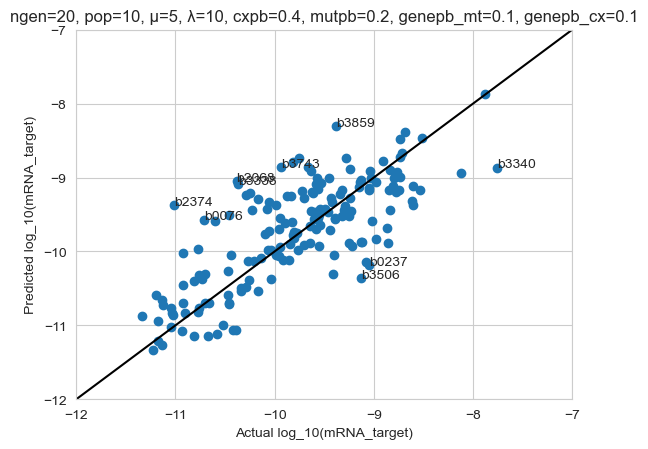

In [56]:
# Scatter of predicted vs actual
fig, ax = plt.subplots()
title = 'ngen='+str(ngen)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', genepb_mt='+str(genepb_mt)+', genepb_cx='+str(genepb_cx)
ax.set_title(title)
ax.scatter(y_lockbox.iloc[:,0], prediction_df.iloc[:,-1])

for gene in dist_from_line.index:
    if np.abs(dist_from_line.loc[gene].values) > cutoff:
        ax.text(x = y_lockbox.loc[gene,'log10_mRNA_target'],
                y = prediction_df.loc[gene,'mRNA_prediction'],
                s = gene)
        
ax.set_xlabel('Actual log_10(mRNA_target)')
ax.set_ylabel('Predicted log_10(mRNA_target)')
ax.axline(p1,slope=1,c='k')
ax.set_xlim(-12,-7)
ax.set_ylim(-12,-7)
fig.show()

## Minimum Fitness vs Generation

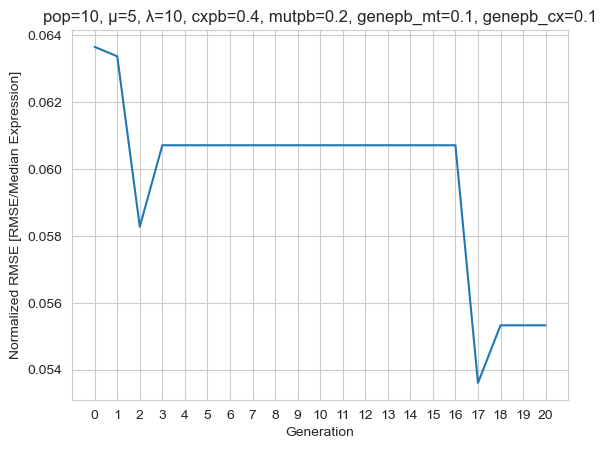

In [57]:
# Plot fitness of best individuals over time and compare to hof
gen = np.linspace(0, ngen, ngen+1)
gen_min = []

for gen_dict in logbook:
    gen_min.append(gen_dict['min'])

plt.figure()
title = 'pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', genepb_mt='+str(genepb_mt)+', genepb_cx='+str(genepb_cx)
plt.plot(gen, gen_min)
plt.title(title)
plt.xlabel('Generation')
plt.xticks(gen)
plt.ylabel('Normalized RMSE [RMSE/Median Expression]')
plt.show()

## -10 Binding Strength vs k_d_RNAP

In [171]:
# Identify indices that are in both
filtered_pred_index = prediction_df.index.isin(box10_avg.index)
filtered_box10_index = box10_avg.index.isin(prediction_df.index)\

# Filter to genes in both lockbox and box10 score dataframe
prediction_df_filtered = prediction_df[filtered_pred_index]
box10_filtered = box10_avg[filtered_box10_index]

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


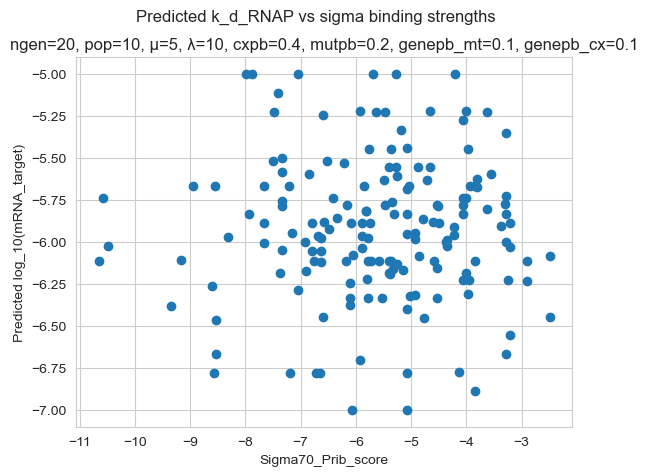

In [180]:
# Scatter of k_d_RNAP vs binding strengths
fig, ax = plt.subplots()
title = 'ngen='+str(ngen)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', genepb_mt='+str(genepb_mt)+', genepb_cx='+str(genepb_cx)
fig.suptitle('Predicted k_d_RNAP vs sigma binding strengths')
ax.set_title(title)
ax.scatter(box10_filtered.loc[:,'Sigma70_Prib_score'], prediction_df_filtered.loc[:,'k_d_RNAP'])
ax.set_xlabel('Sigma70_Prib_score')
ax.set_ylabel('Predicted log_10(mRNA_target)')
fig.show()

## mRNA Expression vs Each Parameter

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


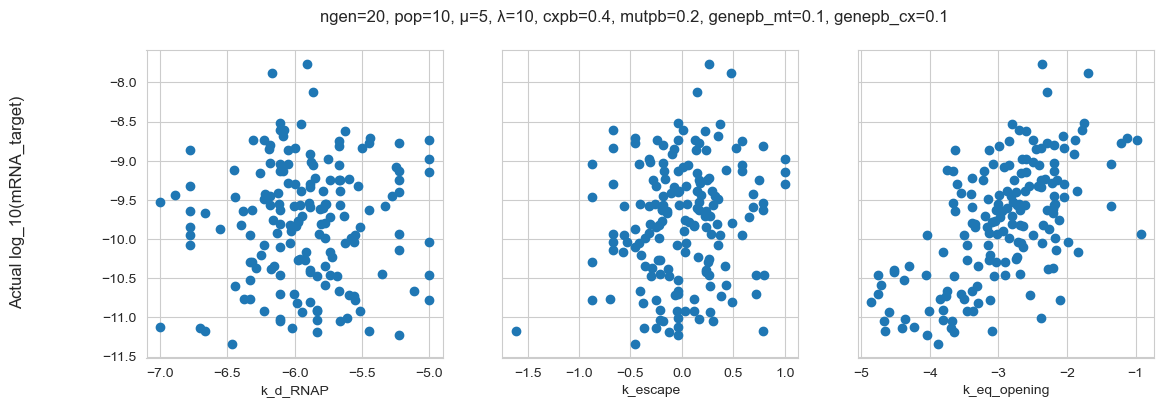

In [201]:
# Scatter of predicted vs parameter
fig, ax = plt.subplots(1,3,sharey=True,figsize=(13,4))
title = 'ngen='+str(ngen)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', genepb_mt='+str(genepb_mt)+', genepb_cx='+str(genepb_cx)
fig.suptitle(title)
fig.supylabel('Actual log_10(mRNA_target)')

for i, parameter in enumerate(parameter_list):
    # Predicted vs k_d_RNAP
    ax[i].scatter(prediction_df.iloc[:,i], y_lockbox.iloc[:,0])
    ax[i].set_xlabel(parameter)

fig.show()

## Shap Plots (Need to update)

In [92]:
# Create Shap plots for each parameter
# NOTE: Need to confirm that I am getting the exact same model each time I train on the same data
shap_df = pd.DataFrame(columns = parameter_list, index = x_train.index)

for i, k_values in enumerate(hof[0]):
    shap_df.iloc[i,:] = k_values[:]

for i in range(len(parameter_list)):
    fit_model = model.fit(x_train, hof[0][:,i])
    explainer = shap.Explainer(fit_model.predict, x_lockbox)
    shap_values = explainer(x_lockbox)
    fig = plt.figure()
    shap.plots.beeswarm(shap_values, show=False)
    plt.title(parameter_list[i])
    plt.show()

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


KeyboardInterrupt: 

In [ ]:
# Create Shap plots for each parameter
shap_df = pd.DataFrame(columns = parameter_list, index = x_train.index)

for i, k_values in enumerate(hof[0]):
    shap_df.iloc[i,:] = k_values[:]

for i in range(len(parameter_list)):
    fit_model = model.fit(x_train, hof[0][:,i])
    explainer = shap.Explainer(fit_model.predict, x_lockbox)
    shap_values = explainer(x_lockbox)
    fig = plt.figure()
    shap.plots.beeswarm(shap_values, show=False)
    plt.title(parameter_list[i])
    plt.show()

# Editing Promoter Solving Core Functions
- Might need to use the lambdify function to evaluate the expression at many points more quickly
- simplify() is okay when working with the expressions directly, but should functionalize the code by using the actual simplification functions (e.g. factor() instead of simplify())

In [100]:
# Define constants and convert to symbols
t_half_life_deg = 300

constant_vals = {
    'k_d_TF': 1, # May change depending on model
    'RNAP': 10**-6, # Concentration of RNAP
    'TF': 0, # Concentration of TF
    'u': 1/3600, # Growth Rate
    'k_deg': np.log(2)/t_half_life_deg, # Rate of degradation
    'promoter': 10**-9, # Promoter concentration
    # 'TFI': 0,
    'mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
}

In [23]:
test_expr = sympify('Eq((k_d_TFI*k_eq_opening*k_escape*promoter*RNAP)/((k_d_TFI*(2+k_eq_opening)*RNAP+k_d_RNAP*(k_d_TFI+TFI))*(k_deg+u)),mRNA)')
test_expr

Eq(RNAP*k_d_TFI*k_eq_opening*k_escape*promoter/((k_deg + u)*(RNAP*k_d_TFI*(k_eq_opening + 2) + k_d_RNAP*(TFI + k_d_TFI))), mRNA)

In [19]:
test_default = sympify('Eq((KeqOpening*kEscape*promoterConcVal)/((KdRNAP/RNAP+1+KeqOpening+KdRNAP/RNAP*TF/k_d_TF)*(u+kDeg)),mRNA)')
#test_default.subs(constant_vals.items())
test_default

Eq(KeqOpening*kEscape*promoterConcVal/((kDeg + u)*(KdRNAP*TF/(RNAP*k_d_TF) + KdRNAP/RNAP + KeqOpening + 1)), mRNA)

In [ ]:
KdRNAP,
 KdRNAPCrp,
 KeqOpening,
 RNAP,
 cActivator,
 kDeg,
 kEscape,
 mRNA,
 promoterConcVal,
 u

In [25]:
10**-9/((np.log(2)/t_half_life_deg)-1/3600)

4.919534073625545e-07

In [102]:
lambda_df = create_lambdas(test_default,constant_vals)
lambda_df

,equation,lambda,order
k_d_RNAP,[2.0e-27*(193179348761631.0*k_eq_opening*k_esc...,<function _lambdifygenerated at 0x28b34b5b0>,"(k_eq_opening, k_escape, mRNA)"
k_eq_opening,[5.0e+20*mRNA*(1000000.0*k_d_RNAP + 1.0)/(1931...,<function _lambdifygenerated at 0x2b2c64af0>,"(k_d_RNAP, k_escape, mRNA)"
k_escape,[2588268.37964426*mRNA*(1000000.0*k_d_RNAP + k...,<function _lambdifygenerated at 0x2b2c649d0>,"(k_d_RNAP, k_eq_opening, mRNA)"
mRNA,[3.86358697523262e-7*k_eq_opening*k_escape/(10...,<function _lambdifygenerated at 0x2b2c65000>,"(k_d_RNAP, k_eq_opening, k_escape)"


In [5]:
10**-8.368632

4.279253356644282e-09

In [39]:
lambda_df.loc['mRNA','lambda']((10**-7,10**-1.300409563581135,10**-0.5944885496181157))

[4.2792508541164465e-09]

In [51]:
test_expr = sympify('Eq(cActivator,-((KdRNAPCrp*(kDeg*mRNA*(KdRNAP + RNAP + KeqOpening*RNAP) + \
mRNA*(KdRNAP + RNAP)*u + KeqOpening*(-(kEscape*promoterConcVal*RNAP) \
+ mRNA*RNAP*u)))/(KdRNAP*(kDeg*mRNA*(KdRNAPCrp + RNAP + \
KeqOpening*RNAP) + mRNA*(KdRNAPCrp + RNAP)*u + \
KeqOpening*(-(kEscape*promoterConcVal*RNAP) + mRNA*RNAP*u)))))')
test_expr

Eq(cActivator, -KdRNAPCrp*(KeqOpening*(-RNAP*kEscape*promoterConcVal + RNAP*mRNA*u) + kDeg*mRNA*(KdRNAP + KeqOpening*RNAP + RNAP) + mRNA*u*(KdRNAP + RNAP))/(KdRNAP*(KeqOpening*(-RNAP*kEscape*promoterConcVal + RNAP*mRNA*u) + kDeg*mRNA*(KdRNAPCrp + KeqOpening*RNAP + RNAP) + mRNA*u*(KdRNAPCrp + RNAP))))

In [73]:
subs_expr = test_expr.subs('cActivator', 0)
subs_expr

Eq(0, -KdRNAPCrp*(KeqOpening*(-RNAP*kEscape*promoterConcVal + RNAP*mRNA*u) + kDeg*mRNA*(KdRNAP + KeqOpening*RNAP + RNAP) + mRNA*u*(KdRNAP + RNAP))/(KdRNAP*(KeqOpening*(-RNAP*kEscape*promoterConcVal + RNAP*mRNA*u) + kDeg*mRNA*(KdRNAPCrp + KeqOpening*RNAP + RNAP) + mRNA*u*(KdRNAPCrp + RNAP))))

In [52]:
test_expr.free_symbols

{KdRNAP,
 KdRNAPCrp,
 KeqOpening,
 RNAP,
 cActivator,
 kDeg,
 kEscape,
 mRNA,
 promoterConcVal,
 u}

In [20]:
# Define constants and convert to symbols
t_half_life_deg = 300

test_constants = {
    'k_d_TF': 1, # May change depending on model
    'RNAP': 10**-6, # Concentration of RNAP
    'TF': 0, # Concentration of TF
    'u': 1/3600, # Growth Rate
    'kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'promoterConcVal': 10**-9, # Promoter concentration
    #'cActivator': 0,
    #'KdRNAPCrp': 1,
    'mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
}

In [54]:
test_lambda = create_lambdas(test_expr, test_constants)
test_lambda

,equation,lambda,order
cActivator,[KdRNAPCrp*(-1.16472077083992e+22*KdRNAP*mRNA ...,<function _lambdifygenerated at 0x2b5a395a0>,"(KdRNAP, KdRNAPCrp, KeqOpening, kEscape, mRNA)"
KdRNAP,[KdRNAPCrp*(4500000000.0*KeqOpening*kEscape - ...,<function _lambdifygenerated at 0x2b5a39ea0>,"(cActivator, KdRNAPCrp, KeqOpening, kEscape, m..."
KdRNAPCrp,[KdRNAP*cActivator*(4500000000.0*KeqOpening*kE...,<function _lambdifygenerated at 0x2b5a38670>,"(cActivator, KdRNAP, KeqOpening, kEscape, mRNA)"
KeqOpening,[1.29413418982213e+15*mRNA*(1000000.0*KdRNAP*K...,<function _lambdifygenerated at 0x2b5a39c60>,"(cActivator, KdRNAP, KdRNAPCrp, kEscape, mRNA)"
kEscape,[2.22222222222222e-10*mRNA*(1.16472077083992e+...,<function _lambdifygenerated at 0x2b5a3a7a0>,"(cActivator, KdRNAP, KdRNAPCrp, KeqOpening, mRNA)"
mRNA,[4500000000.0*KeqOpening*kEscape*(KdRNAP*cActi...,<function _lambdifygenerated at 0x2b5a3a830>,"(cActivator, KdRNAP, KdRNAPCrp, KeqOpening, kE..."


In [55]:
print(test_lambda.loc['KeqOpening','equation'])

[1.29413418982213e+15*mRNA*(1000000.0*KdRNAP*KdRNAPCrp*cActivator + 1000000.0*KdRNAP*KdRNAPCrp + KdRNAP*cActivator + KdRNAPCrp)/(500000000.0*KdRNAP*cActivator*kEscape - 1.29413418982213e+15*KdRNAP*cActivator*mRNA + 500000000.0*KdRNAPCrp*kEscape - 1.29413418982213e+15*KdRNAPCrp*mRNA)]


In [22]:
log_test = {
    'KdRNAP': [-7,-5],
    #'KdRNAPCrp': [-9,-7],
    'kEscape': [-3,1],
    #'cActivator': [-1.3010299956639813, -0.6989700043360187],
}

In [118]:
(11.12875+11.24441803)/2

11.186584015000001

In [23]:
lambda_df, k_df = create_grid([2**7.094120257],['b1101'],test_default,test_constants,5,**log_test)

In [24]:
lambda_df

,equation,lambda,order
KdRNAP,[2.0e-27*(193179348761631.0*KeqOpening*kEscape...,<function _lambdifygenerated at 0x2b7f9fb50>,"(KeqOpening, kEscape, mRNA)"
KeqOpening,[5.0e+20*mRNA*(1000000.0*KdRNAP + 1.0)/(193179...,<function _lambdifygenerated at 0x2b7ef6950>,"(KdRNAP, kEscape, mRNA)"
kEscape,[2588268.37964426*mRNA*(1000000.0*KdRNAP + Keq...,<function _lambdifygenerated at 0x2b7ef44c0>,"(KdRNAP, KeqOpening, mRNA)"
mRNA,[3.86358697523262e-7*KeqOpening*kEscape/(10000...,<function _lambdifygenerated at 0x2b7ef7520>,"(KdRNAP, KeqOpening, kEscape)"


In [26]:
k_df

,log10_mRNA_target,parameter_grid
gene_name,,
b1101,-9.388925,"[(-7.0, -2.9305929704042426, 1.000000000000000..."


In [25]:
k_df.loc['b1101','parameter_grid']

[(-7.0, -2.9305929704042426, 1.0000000000000002),
 (-7.0, -1.9479447278031818, -0.9438206068692357),
 (-7.0, -0.9652964852021213, -1.9649679269779003),
 (-7.0, 0.017351757398939238, -2.951433718067943),
 (-7.0, 1.0, -3.934477355721568),
 (-6.5, -2.9305929704042426, 1.0779383629078698),
 (-6.5, -1.9479447278031818, -0.8658822439613663),
 (-6.5, -0.9652964852021213, -1.887029564070031),
 (-6.5, 0.017351757398939238, -2.873495355160074),
 (-6.5, 1.0, -3.8565389928136984),
 (-6.0, -2.9305929704042426, 1.2596373105057563),
 (-6.0, -1.9479447278031818, -0.6841832963634796),
 (-6.0, -0.9652964852021213, -1.7053306164721442),
 (-6.0, 0.017351757398939238, -2.691796407562187),
 (-6.0, 1.0, -3.674840045215812),
 (-5.5, -2.9305929704042426, 1.5779383629078698),
 (-5.5, -1.9479447278031818, -0.36588224396136626),
 (-5.5, -0.9652964852021213, -1.387029564070031),
 (-5.5, 0.017351757398939238, -2.373495355160074),
 (-5.5, 1.0, -3.3565389928136984),
 (-5.0, -2.9305929704042426, 2.0000000000000004),
 

In [60]:
lambda_df.loc['mRNA','order']

('cActivator', 'KdRNAP', 'KdRNAPCrp', 'KeqOpening', 'kEscape')

In [61]:
values = {
    'KdRNAP': -5,
    'KdRNAPCrp': -6,
    'KeqOpening': -1.1139596458495244,
    'kEscape': 0.2027557251909421,
}

results = []

for cActivator in np.arange(0,0.6,0.01):
    values['cActivator'] = cActivator
    results.append(10**evaluate_lambda('mRNA',lambda_df,values))

Text(0, 0.5, 'cActivator')

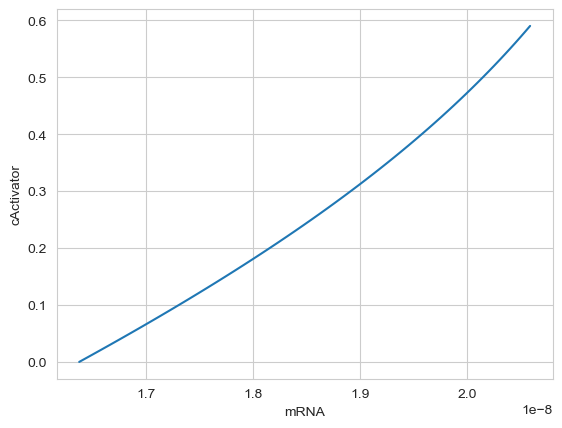

In [62]:
fig, ax = plt.subplots()
ax.plot(results,np.arange(0,0.6,0.01))
ax.set_xlabel('mRNA')
ax.set_ylabel('cActivator')

In [74]:
10**k_df.loc['b1101','log10_mRNA_target']

-19.269487876757903

In [37]:
range(0,0.6,0.1)

TypeError: 'float' object cannot be interpreted as an integer